In [1]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import add_dummy_feature
from sklearn import linear_model
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(4,4)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)

# Motivación

En el cuaderno anterior hemos aprendido que tanto clasificación como regresión se pueden resolver utilizando la solución matricial de un problema de regresión.

De ello se concluye que, en definitiva, la clasificación no es más que un problema de regresión donde el valor objetivo (_target_) es categórico (o discreto) en vez de continuo.<br>
O dicho de otro modo, que un problema de regresión es un problema de clasificación con infinitas etiquetas.

PERO **NO parece muy lógico** que utilicemos la solución de regresión para un número finito de etiquetas.<br> **¡¿No hay otro modo?!**
$\rightarrow\fbox{Sí}~$

Vamos a aprender un modo de hacer "regresión" cuando el valor objetivo es **binario**, que ADEMÁS, nos devuelve una medida de probabilidad.

**¡ Importante !**&nbsp;&nbsp;
Tener una medida de probabilidad da una significado a la predicción.

# Elementos matemáticos necesarios

Necesitaremos de la función sigmoide "por excelencia": la función logística.
Así que vamos a comenzar distinguiéndolas.


## Funciones Sigmoide

Son funciones cuya gráfica tiene forma de _S_.

Formalmente, es cualquier función $S$ que cumple:
- $S:\mathbb R \rightarrow (a,b)$ con $a < b$, o sea real y acotada
- Es diferenciable con una derivada no negativa en cada punto y sólo 1 punto de inflexión; es decir que siempre crece y, como ya hemos dicho, tiene forma de _S_.

Hay muchas funciones que cumplen estas dos propiedades y por tanto son sigmoides.<br>
Por ejemplo:

| Nombre | Expresión |
|--------|-----------|
|**Logística**| $S(x)$  =  $\frac{1}{1+e^{-x}}$|
|Tangente hiperbólica | $S(x)$ = $\tanh$$(x)$|
|Arcotangente | $S(x)$ = $\arctan$$(x)$|
|Función error| $S(x)$ = $\frac{2}{\sqrt{\pi}}$$\int\limits_0^x e^{-t^2}dt$|
| y también funciones algebraicas como | $S(x)$=$\frac{x}{\sqrt{1+x^2}}$|


## Función Logística
Como acabamos de ver, es una función Sigmoide en particular.
$$S(x) = \frac{1}{1+e^{-x}}$$
donde $x$ hace referencia a la entrada de la función, no a un ejemplo del conjunto de datos.

Esta función tiene las siguientes propiedades:
- Es continua y siempre creciente
- $\quad \lim\limits_{x\rightarrow -\infty} S(x) = 0$
- $\quad \lim\limits_{x\rightarrow +\infty} S(x) = 1$

Por tanto **cumple las condiciones para ser una distribución de probabilidad** (_Cumulative Distribution Function_ o CDF).

Vamos a ver qué pinta tiene con el siguiente código


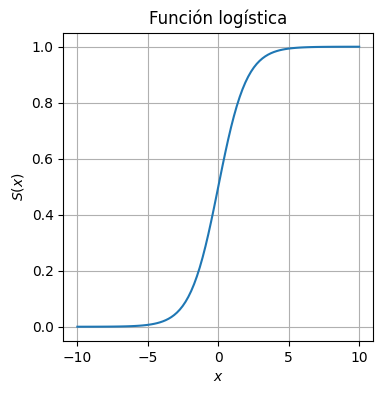

In [2]:
# Crear la función logística para un array de Ns elementos
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Generar un rango de valores para x
Ns = 100   #<- Número de muestras en el eje horizontal (x)
bound = 10 #<- límites de la figura en horizontal: [-bound, +bound]
x = np.linspace(-bound, bound, Ns)

# Calcular los valores de la función logística para cada valor de x
y = logistic(x)

# Dibujar
plt.plot(x, y)

plt.title('Función logística')
plt.xlabel('$x$'); plt.ylabel('$S(x)$')
plt.grid()
plt.show()



# Regresión logística

Cuando, en el cuaderno anterior, obtuvimos un clasificador mendiante regresión, la superficie de decisión era el lugar geométrico de todos los puntos que satisfacían la ecuación implícita de dicha superficie; en el caso lineal un hiperplano.

Por tanto, un ejemplo $~\bf x = (1, x_1, \ldots, x_D)^\top$ evaluado en el hiperplano que representa el modelo $f({\bf w},{\bf x}) = {\bf w}^\top{\bf x}~~$ puede dar tres resultados:
<br>
$\quad f({\bf w},{\bf x})=0$, entonces el ejemplo $\bf x$ está **exactamente sobre** el hiperplano de decisión.
<br>
$\left.\begin{matrix}
\quad f({\bf w},{\bf x})>0\\
\quad f({\bf w},{\bf x})<0
\end{matrix}\right\rbrace$,
entonces el ejemplo está **separado** del hiperplano de decisión, por un lado o por el otro.

En este último caso, dependiendo del ejemplo, la separacíón puede ser pequeña o grande. No hay límites.

PERO lo que buscamos es asignar una etiqueta a cada ejemplo, no saber a qué distancia se encuentra del plano de decisión. <br>

Esta claro que si está muy lejos es lo mismo que si esta muy-muy-muy lejos.<br>
Por tanto podríamos pensar en **saturar** el valor de $ f({\bf w},{\bf x})$ de modo que por encima de esa saturación valga siempre lo mismo.

La función sigmoide se encarga de hacer esta saturación de $ f({\bf w},{\bf x})$, convirtiendolo a una medida de la probabilidad de que el ejemplo pertenezca a una de las dos clases.

Sea &nbsp;**Logit**&nbsp; el nombre que recibe el resultado de la función lineal $ ~~f({\bf w},{\bf x}) = {\bf w}^\top{\bf x}.$

Entonces, la función logística aplicada al logit nos devuelve una medida de la probabilidad de que $\bf x$ pertenezca a la clase "$+1$", más exactamente:
$$
 \Pr(y=+1|\text{logit}={\bf w}^\top{\bf x}) =
\frac{1}{1+e^{-{\bf w}^\top{\bf x}}}
$$


## Aprendizaje

No hay que explicar nada nuevo porque los parámetros son los de un modelo lineal.

Simplemente hay que transformar el resultado mediante la función logística.

## Ejemplo con `LinearRegression` + Función loǵistica

Retomamos el ejemplo del cuaderno anterior sobre modelos lineales de clasificación binaria para rehacerlo mediante regresión logística.

In [3]:
seed = 1460
np.random.seed(seed=seed)

# Función que genera pares (x_1, x_2) con la misma etiqueta
def generateX_2D(N, mu=0, sigma=1, label=1):
  data = np.random.normal(mu, sigma, (N, 2))
  df = pd.DataFrame(data, columns=["x1", "x2"])
  df["y"] = np.ones(N)*label
  return df

# Función que genera pares (x_1, x_2) de varias etiquetas
def generate_XY(N, mu, sigma, label):
  df0 = generateX_2D(N, mu[0], sigma[0], label[0])
  df1 = generateX_2D(N, mu[1], sigma[1], label[1])
  df = pd.concat([df0,df1], axis=0)
  df = df.sample(2*N, ignore_index=True)
  return df

#-- generación del conjunto de datos para el ejemplo
N = 20
mu = [-1,1]
sigma = [1,1]
label = [-1,1]
df = generate_XY(N,mu,sigma,label)

#-- Aprendizaje del modelo lineal
X = df[['x1','x2']]
Y = df['y']
reg = linear_model.LinearRegression()
reg.fit(X,Y)
print(f'Los parámetros aprendidos para un modelo lineal son:')
print(f' w = {reg.coef_} , w0 = {reg.intercept_:0.2f}')


Los parámetros aprendidos para un modelo lineal son:
 w = [0.31 0.27] , w0 = 0.05


Una vez tenemos el modelo lineal que devuelve
$$\text{logit} = {\bf w}^\top{\bf x}$$
donde $~{\bf w}~$ incluye a $w_0$ y por tanto $~{\bf x}~$ está extendido con una característica _dummy_=1<br>
ya podemos calcular la probabilidad de que cada ejemplo sea de la etiqueta "$+1$" (o siemplemente "1"), es decir que su logit sea positivo.

In [4]:
#-- Obtenemos los logits
logit = reg.predict(X)

#-- Convertimos los logits en probabilidad de pertenecer a la clase "1"
def logistic_fun(x):
    return 1 / (1 + np.exp(-x))

Añadimos los logits y la $~p(y=1)~$ al dataframe y mostramos los 5 primeros ejemplos.

In [5]:
df["logit"]=logit
df['p(y=1)']=logistic_fun(logit)
df.head()

,x1,x2,y,logit,p(y=1)
0,1.6254,2.2302,1.0,1.1511,0.7597
1,-0.7525,0.4368,1.0,-0.0640,0.4840
2,-1.1499,-0.1234,1.0,-0.3364,0.4167
3,1.2272,1.0272,1.0,0.7072,0.6698
4,1.8336,0.8391,1.0,0.8452,0.6996


Mostramos en una figura los logits de cada ejemplo (puntos azules) sobre la función logística (línea discontinua amarilla).

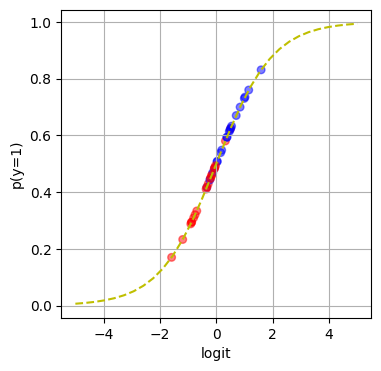

In [6]:
colors=df['y'].copy()
colors[colors==1]='b'
colors[colors==-1]='r'
df.plot.scatter(x='logit', y='p(y=1)', c=colors, s=30, alpha=0.5)
range_logit = np.linspace(-5,5,30)
plt.plot(range_logit, logistic_fun(range_logit), 'y--')
plt.grid()
plt.show()

En la figura se aprecia algo muy importante:
- Para casi todos los logits **positivos** tenemos:
  - un punto **azul**, es decir un ejemplo de la clase "+1"
  - una probabilidad $p(y=1) > 0.5$
- Para casi todos  los logits **negativos** tenemos:
  - un punto **rojo**, es decir un ejemplo de la clase "-1"
  - una probabilidad $p(y=1) < 0.5$<br>
  PERO como solo hay dos posibles eventos $~\{y=+1~,~y=-1\}~$ entonces
  $p(y=1) = 1-p(y=0)$, <br>
  por tnato tenemos $p(y=-1)>0.5$.

**En definitiva**<br>
La regresión logística nos devuelve una medida de la probabilidad de que un ejemplo dado pertenezca a una clase y por tanto también una medida de probabilidad de pertenecer al resto de clases (o a la otra clase si solo hay dos)



## Ejemplo con `LogisticRegression`

Obviamente Scikit-Learn incluye la regresión logística entre sus modelos lineales.

Vamos a repetir el ejemplo.

In [7]:
#- Instanciamos un objeto de Regresion logística
logreg = linear_model.LogisticRegression()
#- Lo entrenamos con los datos dados
logreg.fit(X,Y)
#- Hacemos la predicción de la clase y también
#  la estimación de la probabilidad de pertenecer a cada clase
y_hat = logreg.predict(X)
prob  = logreg.predict_proba(X)

Para mostrarlo añadimos estos dos resultados al dataframe que teníamos y mostramos los 10 primeros ejemplos.

**¡ Cuidado !**<br>
El método `predict_proba`  de  `LogisticRegression` devuelve un array con **dos** columnas:
- la probabilidad de pertenecer a la clase "+1"
- la probabilidad de pertenecer a la clase "-1"


In [8]:
df['y_hat']=y_hat
df['prob y=-1'] =prob[:,0]
df['prob y=+1'] =prob[:,1]
df.head(10)

,x1,x2,y,logit,p(y=1),y_hat,prob y=-1,prob y=+1
0,1.6254,2.2302,1.0,1.1511,0.7597,1.0,0.0199,0.9801
1,-0.7525,0.4368,1.0,-0.0640,0.4840,-1.0,0.5396,0.4604
2,-1.1499,-0.1234,1.0,-0.3364,0.4167,-1.0,0.7471,0.2529
3,1.2272,1.0272,1.0,0.7072,0.6698,1.0,0.0861,0.9139
4,1.8336,0.8391,1.0,0.8452,0.6996,1.0,0.0581,0.9419
5,0.7155,-0.9023,1.0,0.0347,0.5087,1.0,0.4932,0.5068
6,0.5398,-1.3928,-1.0,-0.1504,0.4625,-1.0,0.6483,0.3517
7,2.2927,3.1072,1.0,1.5916,0.8308,1.0,0.0045,0.9955
8,1.2047,0.2865,-1.0,0.5030,0.6232,1.0,0.1627,0.8373
9,0.7138,0.1854,-1.0,0.3238,0.5803,1.0,0.2581,0.7419


En la tabla podemos ver que:
- `y_hat` coincide en 8 de las 10 filas con $y$. <br>
Sólo se "equivoca" en el ejemplo #1 y en el #2.
- Cuando acierta con la prediccion de la clase "+1", la `prob y=+1` es mayor que 0.5. <br>
(ejemlos 0, 3, 4, 5, 7, 8 y 9)
- Cuando acierta con la prediccion de la clase "-1", la `prob y=+1` es menor que 0.5, y por tanto la `prob y=-1` es mayor que 0.5.<br>
(ejemlo 6)


Para terminar este ejemplo, creamos una figura donde se pueda "ver" la probabilidad asignada a cada punto del espacio $\mathbb R^2$

En primer lugar hacemos un barrido con `linspace` de ambos ejes y realizamos todos los cruces posibles con `meshgrid`.

In [9]:
rangeX1 = np.linspace(-bound,bound,Ns) #<-"bound" y "Ns" fueron
rangeX2 = np.linspace(-bound,bound,Ns) #<-definidos al inicio
XX1,XX2  = np.meshgrid(rangeX1, rangeX2)
df_space2D = pd.DataFrame({'x1':XX1.reshape(Ns*Ns), 'x2':XX2.reshape(Ns*Ns)})

A continuación calculamos la probabilidad estimada por el modelo de regresión logística para cada punto del barrido que hemos hecho en el espacio 2D.

Finalmente pintamos con cruces azules los ejemplos con etiqueta "+1" y con circulos rojos los que tienen etiqueta "-1".

También pintamos el plano de decisión con el truco de usar un `contour` al nivel 0.5.

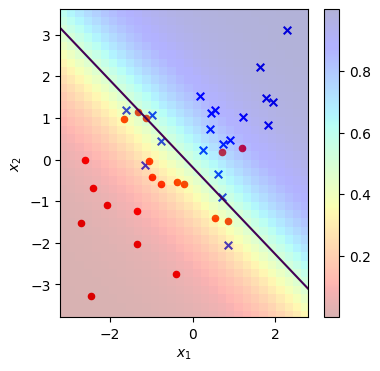

In [19]:
prob_space2D = logreg.predict_proba(df_space2D)
p_class1 = prob_space2D[:,1]
plt.contour(rangeX1, rangeX2, p_class1.reshape(Ns,Ns),levels=[0.5])

plt.scatter(X[Y==1]['x1'], X[Y==1]['x2'], c='b', marker='x', s=30)
plt.scatter(X[Y==-1]['x1'],X[Y==-1]['x2'],c='r', marker='o', s=20)
plt.pcolormesh(rangeX1, rangeX2, p_class1.reshape(Ns,Ns), cmap='jet_r', alpha=0.3)
plt.axis([X['x1'].min()-0.5 , X['x1'].max()+0.5, X['x2'].min()-0.5 , X['x2'].max()+0.5])
plt.colorbar()
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.show()

# Cosas importantes


## ¿La regresión logística es un modelo lineal?

La utilización de la función logística, que obviamente es una función NO lineal, da lugar a esta duda.

Como se ha visto, Scikit-learn incluye la clase `LogisticRegression` en la biblioteca de modelos lineales.

En realidad es un **modelo lineal generalizado** ya que los logits sí se calculan mediante un modelo lineal.

La función logística simplemente nos sirve para dar una estimación de la probabilidad de pertenecer a una clase; pero el modelo de los datos sigue siendo un modelo lineal.

## La regresión logística **también** tiene una función discriminante

En los ejemplos que hemos hecho la etiqueta "+1" o "-1" se asignaba según la probabilidad fuera mayor o menor del 50%. <br>
PERO eso no deja de ser una umbralización de la forma

$$
\hat y = \left\lbrace
\begin{array}{llll}
+1 & \text{si} & \hat p > \theta \\
-1 & \text{si} & \hat p \le \theta
\end{array}
\right.
\quad\text{donde}\quad
\hat p = \frac{1}{1+e^{-{\bf w}^\top{\bf x}}}
$$
con $\theta = 0.5$.

De hecho, según el dominio de la aplicación, nos puede interesar ser más restrictivos o más laxos a la hora de fijar el umbral.

<u>Ejemplos</u>
- En **detección de fraude** es preferible **bajar el umbral** para ser laxo en cuanto a clasificar una transacción como fraudulenta. <br>
Posiblemente nos equivoquemos en muchas que son legítimas, pero nos aseguramos de que no "pasa" ninguna fraudulenta.
- En **filtado de spam** es preferible **subir el umbral** para ser muy restrictivo a la hora de enviar un correo entrante a la papelera ya que el usuario no quiere perder correos buenos.

En cualquier caso, recuerda que en clasificación binaria, cuando se sube el umbral de la probabilidad para asignar la etiqueta "+1" se está bajando a la vez el umbral para asignar la etiqueta "-1" y viceversa.




## `LogisticRegression` tiene un término de regularización L2 por defecto.

**TODOS** los ejemplos que hemos hecho se podrían haber realizado SÓLO con la SÓLO fórmula matricial para la regresión lineal y la función logística.

Para familiarizarnos con Scikit-learn hemos usado `LinearRegression` y `LogisticRegression`, pero no hemos entrado a ver sus opciones.

Entre las opciones de `LogisticRegression` está **penalty**, que por defecto toma "l2", ¡¿qué siginifica?!

El próximo cuaderno está dedicado a otro modo de aprender los parámetros del modelo: **descenso del gradiente de la función de pérdida.** <br>
Ahí entra en juego la **regularización**.

# Ejercicios

Si la función logística es una función de distribución (_Cumulative Distribution Function_ o CDF), escribe el código para pintar su función de densidad de probabilidad (_Probability Density Function_ o PDF)

Modifica el código de los ejemplos para el caso de que al conjunto de datos se le añada una característica _dummy_ = 1.

Modifica los códigos dados para probar diferentes umbrales de probabilidad

Repite el ejercicio largo del cuaderno anterior, pero ahora utilizando regresión logística.